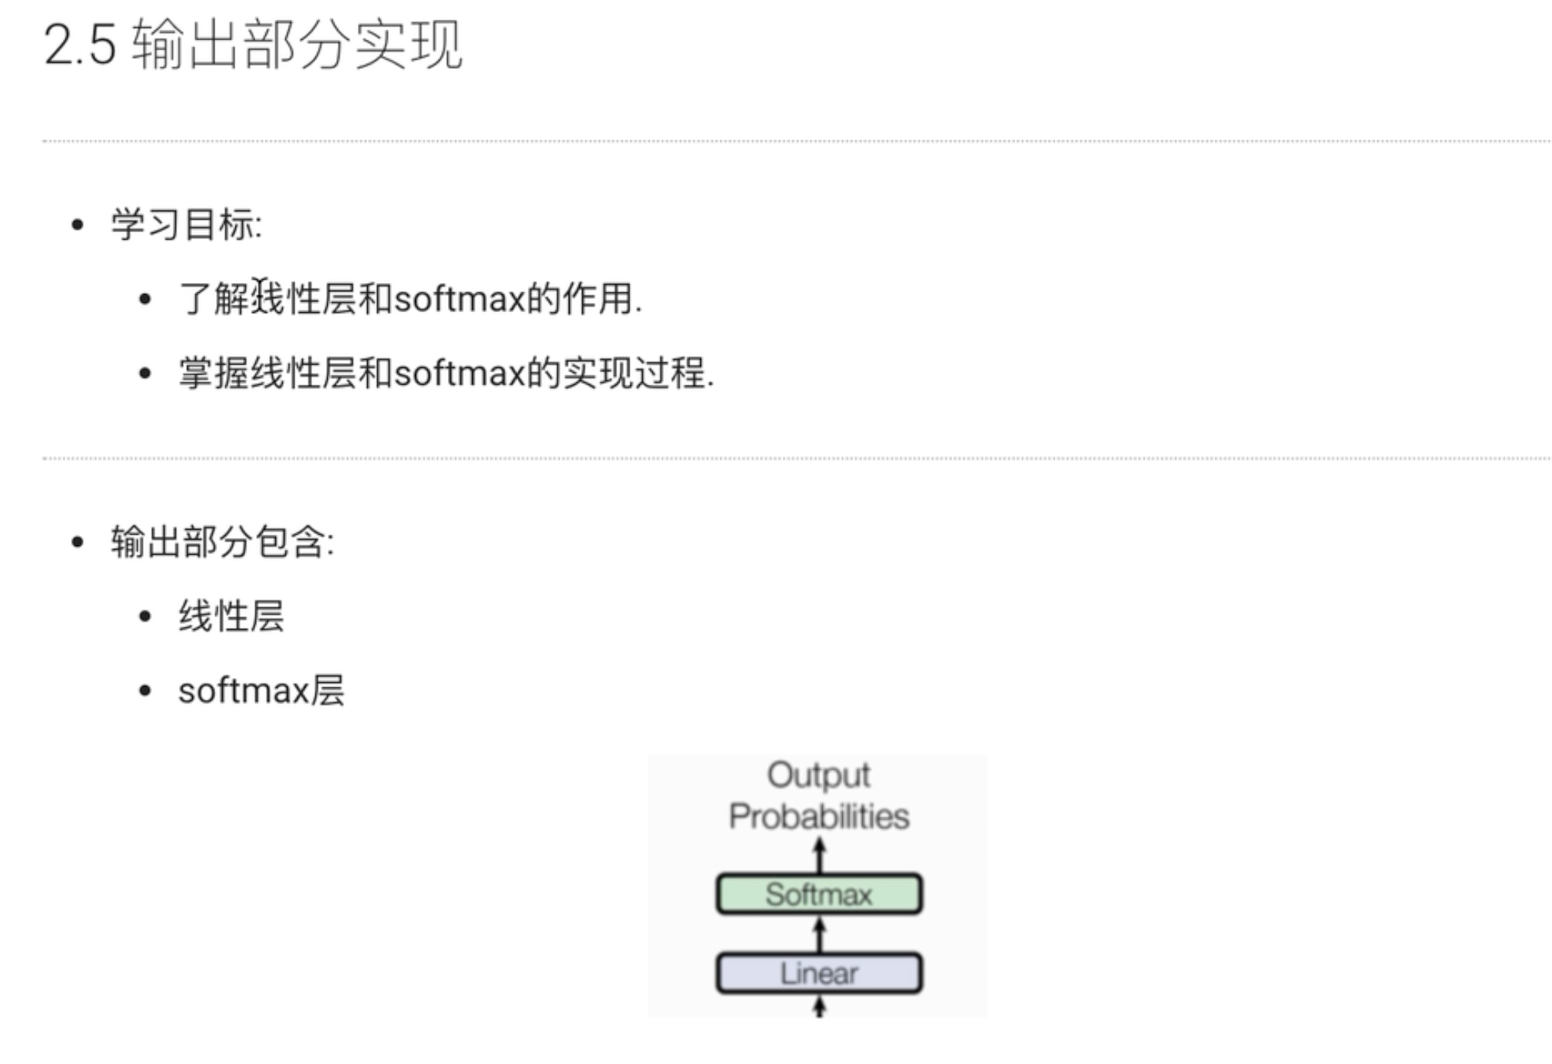

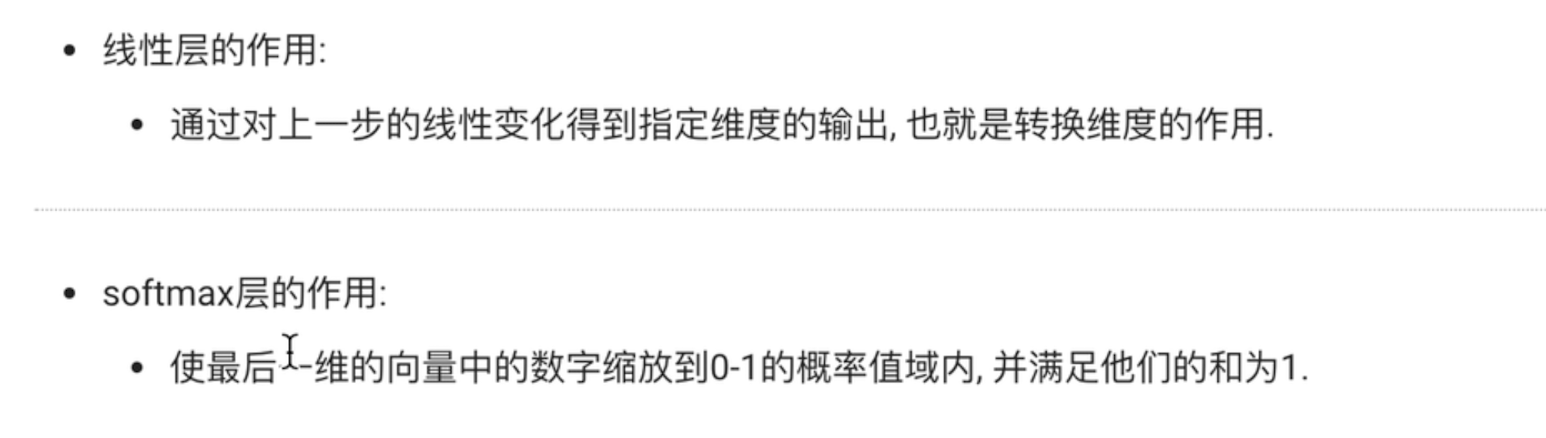

- 线性层和softmax层的代码分析

In [2]:
import copy
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.autograd import Variable


# 创建Embedding类来实现文本嵌入层
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # d_model : 词嵌入的维度
        # vocab : 词表的大小
        super(Embeddings,self).__init__()
        # 定义Embedding层
        self.lut = nn.Embedding(vocab,d_model)
        # 将参数传入类中
        self.d_model = d_model
    def forward(self,x):
        # x: 代表输入进模型的文本通过词汇映射后的数字张量
        return self.lut(x) * math.sqrt(self.d_model)

# 位置编码层
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        # d_model : 代表词嵌入的维度
        # dropout ： 代表Dropout 层的置零比率
        # max_len : 代表每个句子的最长长度
        super(PositionalEncoding,self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len,d_model)
        position = torch.arange(0,max_len).unsqueeze(1)

        # 定义一个变化矩阵div_term,跳跃式的初始化
        div_term = torch.exp(torch.arange(0,d_model,2) * 
                             -(math.log(10000.0) / d_model))
        # 将前面定义的变化矩阵进行奇数，偶数分别赋值
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)

        # 将二维张量扩充成三维张量
        pe = pe.unsqueeze(0)

        # 将位置编码矩阵注册成模型的buffer，这个buffer不是模型中的参数，不跟随优化器同步更新
        # 注册成buffer后我们就可以在模型保存后重新加载的时候，将这个位置编码和模型参数一同加载进来
        self.register_buffer("pe",pe)
    def forward(self,x):
        # x:代表文本序列的词嵌入表示
        # 首先明确pe的编码太长了，将第二个维度
        # 也就是max_len对应的那个维度缩小成x的句子长度同等的长度
        x = x + Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)

# 注意力权重的计算
def attention(query,key,value,mask=None,dropout=None):
    # query，key，value：代表注意力的三个输入张量
    # mask：掩码张量
    # dropout:传入的Dropout实例化对象
    # 首先将query的最后一个维度提取出来，代表的是词嵌入的维度
    d_k  = query.size(-1)

    # 按照注意力计算公式，将query和key的转置进行矩阵乘法，然后除以缩放系数
    scores = torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)

    # 判断是否使用掩码张量
    if mask is not None:
        # 利用mask_fill方法，将掩码张量和0进行位置的意义比较，如果等于0，替换成一个非常小的数
        scores = scores.masked_fill(mask == 0,-1e9)

    # 对scores的最后一个维度上进行softmax操作
    p_attn = F.softmax(scores,dim=-1)

    # 判断是否使用dropout
    if dropout is not None:
        p_attn = dropout(p_attn)

    # 最后一步完成p_attn和value张量的乘法，并返回query注意力表示
    return torch.matmul(p_attn,value),p_attn

# 实现深层拷贝函数，用到多个结构相同的线性层
def clones(module,N):
    # module:代表要克隆的目标网络层
    # N：将module克隆几个
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# 实现多头注意力机制的类
class MultiHeadedAttention(nn.Module):
    def __init__(self,head,embedding_dim,dropout=0.1):
        # head:代表几个头的参数
        # embedding_dim：代表词嵌入的维度
        # dropout：进行Dropout操作时，置零的比率
        super(MultiHeadedAttention,self).__init__()

        # 要确认一个事实：多头的数量head需要整除词嵌入的维度embedding_dim
        assert embedding_dim % head == 0

        # 得到每个头获得的词向量的维度
        self.d_k = embedding_dim // head

        self.head = head
        self.embedding_dim = embedding_dim

        # 获得线性层，要获得4个，分别是Q，K，V以及最终的输出线性层
        self.linears = clones(nn.Linear(embedding_dim,embedding_dim),4)

        # 初始化注意力张量
        self.attn = None

        # 初始化dropout对象
        self.dropout = nn.Dropout(p=dropout)
    def forward(self,query,key,value,mask=None):
        # query,key,value是注意力机制的三个输入张量，mask代表掩码张量
        # 首先判断是否使用掩码张量
        if mask is not None:
            # 使用squeeze将掩码张量进行维度扩充，代表多头中的第n个头
            mask = mask.unsqueeze(0)

        # 得到batch_size
        batch_size = query.size(0)

        # 首先使用zip将网络层和输入数据连接在一起，模型的输出利用view和transpose进行维度和形状的改变
        query,key,value = \
        [model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2)
         for model,x in zip(self.linears,(query,key,value))]
        
        # 将每个头的输出传入到注意力层
        x,self.attn = attention(query,key,value,mask=mask,dropout=self.dropout)

        # 得到每个头的计算结果是4维张量，需要进行形状的转换
        # 前面已经将1,2两个维度进行过转置，在这里要重新转置回来
        # 注意：经历了transpose()方法后，必须使用contiguous方法，不然无法使用view方法
        # contiguous方法 保证 张量在内存上的地址是连续的
        x = x.transpose(1,2).contiguous().view(batch_size,-1,self.head*self.d_k)

        # 最后将x输入线性层列表中的最后一个线性层进行处理，得到最终的多头注意力结构输出
        return self.linears[-1](x)

# 构建前馈全连接网络类
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        # d_model: 词嵌入的维度，同时也是两个线性层的输入维度和输出维度
        # d_ff : 代表第一个线性层的输出维度，和第二个线性层的输入维度（中间隐含层）
        # dropout:经过Dropout层处理时，随机置零比率
        super(PositionwiseFeedForward,self).__init__()

        # 定义两个全连接的线性层
        self.w1 = nn.Linear(d_model,d_ff)
        self.w2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self,x):
        # x:代表来自上一层的输出
        # 首先将x送入第一个线性层网络，然后经过relu函数的激活，再经历dropout层的处理
        # 最后送入第二个线性层
        return self.w2(self.dropout(F.relu(self.w1(x))))

# 构建规范化层的类
class LayerNorm(nn.Module):
    def __init__(self, features,eps=1e-6):
        # 初始化函数有两个参数
        # features：词嵌入的维度
        # eps ： 足够小的数，在规范化的分母中出现，防止分母为0，默认是1e-6
        super(LayerNorm,self).__init__()

        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))

        # 把eps传入类中
        self.eps = eps
    
    def forward(self,x):
        mean = x.mean(-1,keepdim=True)
        std = x.std(-1,keepdim=True)

        return self.a2 * (x-mean)/(std + self.eps) + self.b2

class SublayerConnection(nn.Module):
    def __init__(self,size,dropout=0.1):
        # size ： 词嵌入维度大小
        # dropout ： 对模型结构中的节点数进行随机抑制的比率
        super(SublayerConnection,self).__init__()
        # 实例化了规范化对象self.norm
        self.norm = LayerNorm(size)
        # 使用nn中预定义的dropout实例化一个self.dropout对象
        self.dropout = nn.Dropout(p=dropout)
        self.size = size
    def forward(self,x,sublayer):
        # x ： 代表上一层传入的张量
        # sublayer ： 该子层连接中的子层函数
        # 首先将x进行规范化，然后送入子层函数中处理
        # 处理结果进入dropout层，最后进行残差连接
        return x+self.dropout(sublayer(self.norm(x)))


# 构建编码器层的类
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):
        # size : 代表词嵌入的维度
        # self_attn : 代表传入的多头自注意力子层的实例化对象
        # feed_forward : 代表前馈全连接层实例化对象
        # dropout : 进行dropout操作时的置零比率
        super(EncoderLayer,self).__init__()

        # 将两个实例化对象和参数传入类中
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.size = size

        # 编码器层有两个子层连接结构，使用clones函数进行操作
        self.sublayer = clones(SublayerConnection(size,dropout),2)
    
    def forward(self,x,mask):
        # x : 代表上一层的传入张量
        # mask : 代表掩码张量
        # 首先让x经过第一个子层连接结构，内部包含多头自注意力机制子层
        # 再让张量经过第二个子层连接结构，其中包含前馈全连接网络

        x = self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)


# 构建编码器类Encoder
class Encoder(nn.Module):
    def __init__(self, layer,N):
        # layer ： 代表编码器层
        # N ： 代表编码器中有几个layer       
        super(Encoder,self).__init__()
        # 首先使用clones函数克隆N个编码器层放在self.layers中
        self.layers = clones(layer,N)
        # 初始化一个规范化层，它将用在编码器的最后面
        self.norm = LayerNorm(layer.size)

    def forward(self,x,mask):
        # x代表上一层的输出
        # mask代表掩码张量
        # 首先对克隆的编码器层进行循环，每次都会得到一个新的x
        # x依次经历N个编码器层的处理，最后再经过规范化层就可以输出了
        for layer in self.layers:
            x = layer(x,mask)
        return self.norm(x)



# 实例化参数
d_model = 512
dropout = 0.1
vocab = 1000
max_len = 60

x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))
emb = Embeddings(d_model,vocab)
embr = emb(x)

x = embr
pe = PositionalEncoding(d_model,dropout,max_len)
pe_result = pe(x)

# 多头注意力的参数实例化
head=8
embedding_dim = 512
dropout = 0.2

# 若干输入参数的初始化
query = key = value = pe_result

mask = Variable(torch.zeros(8,4,4))
mha = MultiHeadedAttention(head,embedding_dim,dropout)
mha_result = mha(query,key,value,mask)

d_model = 512
d_ff = 64
dropout = 0.2

x = mha_result
ff = PositionwiseFeedForward(d_model,d_ff,dropout)
ff_result = ff(x)


    
# 实例化参数
features = d_model =512
eps = 1e-6

# 输入参数
# 输入x来自前馈全连接层的输出
x = ff_result

# 调用
ln = LayerNorm(features,eps)
ln_result = ln(x)



# 实例化参数
size = 512
dropout = 0.2
head = 8
d_model = 512

# 令x为位置编码器的输出
x = pe_result
mask = Variable(torch.zeros(8,4,4))

# 假设子层中装的是多头注意力层，实例化这个类
self_attn = MultiHeadedAttention(head,d_model)

# 使用lambda获得一个函数类型的子层
sublayer = lambda x:self_attn(x,x,x,mask)

sc = SublayerConnection(size,dropout)
sc_result = sc(x,sublayer)

# ======= 实例化参数 ======= 
size = d_model = 512
head = 8
d_ff = 64
x = pe_result
dropout = 0.2

self_attn = MultiHeadedAttention(head,d_model)
ff = PositionwiseFeedForward(d_model,d_ff,dropout)
mask = Variable(torch.zeros(8,4,4))

el = EncoderLayer(size,self_attn,ff,dropout)
el_result = el(x,mask)

# ========编码器类========
# 第一个实例化参数layer，它是一个编码器层的实例化对象，因为需要传入编码器层的参数
# 又因为编码器层中的子层是不共享的，因此需要使用深度拷贝各个对象
size = 512
head = 8
d_model = 512
d_ff = 64
c = copy.deepcopy
attn = MultiHeadedAttention(head,d_model)
ff = PositionwiseFeedForward(d_model,d_ff,dropout)
dropout = 0.2
# 编码器层
layer = EncoderLayer(size,c(attn),c(ff),dropout)

# 编码器中编码器层的个数N
N = 8
mask = Variable(torch.zeros(8,4,4))
# 编码器
en = Encoder(layer,N)
en_result = en(x,mask)


# 构建解码器层类
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        # size ： 代表词嵌入的维度
        # self_attn ：代表多头注意力机制的对象
        # src_attn : 代表常规的注意力机制的对象
        # feed_forward：代表前馈全连接层的对象
        # dropout：代表Dropout的置零比率
        super(DecoderLayer,self).__init__()

        # 将参数传入类中
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.dropout = dropout

        # 按照解码器层的结构图，使用clones函数克隆3个子层连接对象
        self.sublayer = clones(SublayerConnection(size,dropout),3)
    def forward(self,x,memory,source_mask,target_mask):
        # x : 代表上一层输入的张量
        # memory ： 代表编码器的语义存储张量
        # source_mask:源数据的掩码张量
        # target_mask : 目标数据的掩码张量
        m = memory

        # 第一步让x经历第一个子层，多头自注意力机制的子层
        # 采用target_mask，为了将解码时未来的信息进行遮掩
        # 比如模型解码第二个字符，只能看见第一个字符信息
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,target_mask))

        # 第二步让x经历第二个子层，常规的注意力机制的子层，Q！=K=V
        # 采用source_mask，为了遮掩掉对结果信息无用的数据
        x = self.sublayer[1](x,lambda x:self.src_attn(x,m,m,source_mask))

        # 第三步让x经历第三个子层，前馈全连接层
        return self.sublayer[2](x,self.feed_forward)
    
size = d_model = 512
head = 8
d_ff = 64
dropout = 0.2

self_attn = src_attn = MultiHeadedAttention(head,d_model,dropout)

ff = PositionwiseFeedForward(d_model,d_ff,dropout)

x = pe_result

memory = en_result

mask = Variable(torch.zeros(8,4,4))
source_mask = target_mask = mask

dl = DecoderLayer(size,self_attn,src_attn,ff,dropout)
dl_result = dl(x,memory,source_mask,target_mask)

# ====  解码器类  ====
# 构建解码器类
class Decoder(nn.Module):
    def __init__(self,layer,N):
        # layer:代表解码器层的对象
        # N：代表layer进行几层的拷贝
        super(Decoder,self).__init__()
        # 利用clones函数克隆N个layer
        self.layers = clones(layer,N)
        # 实例化一个规范化层
        self.norm = LayerNorm(layer.size)

    def forward(self,x,memory,source_mask,target_mask):
        # x:代表目标数据的嵌入表示
        # memory：编码器的输出张量
        # source_mask；源数据的掩码张量
        # target_mask:目标数据的掩码张量
        # 要将x依次经历所有的编码器层处理，最后通过规范化层
        for layer in self.layers:
            x = layer(x,memory,source_mask,target_mask)
        return self.norm(x)
    
size = d_model = 512
head = 8
d_ff = 64
dropout = 0.2
c = copy.deepcopy
attn = MultiHeadedAttention(head,d_model)
ff = PositionwiseFeedForward(d_model,d_ff,dropout)
layer = DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout)

N = 8
x = pe_result
memory = en_result
mask = Variable(torch.zeros(8,4,4))
source_mask = target_mask = mask

de = Decoder(layer,N)
de_result = de(x,memory,source_mask,target_mask)

In [4]:
# nn.functional工具包载了网络层中那些只进行计算，而没有参数的层
import torch.nn.functional as F

# 将线性层和softmax计算层一起实现，因为二者的共同目标是生成最后的结构
# 因此把类的名字叫做Generator，生成器类
class Generator(nn.Module):
    def __init__(self,d_model,vocab_size):
        # 初始化函数的输入参数有两个，d_model代表词嵌入维度
        # vocab_size:词表大小
        super(Generator,self).__init__()
        # 首先就是使用nn中预定义线性层进行实例化，得到一个对象self.project等待使用
        # 这个线性层的参数有两个，就是初始化函数传进来的两个参数：d_model,vocab_size
        self.project = nn.Linear(d_model,vocab_size)

    def forward(self,x):
        # 前向逻辑函数中输入是上一层的输出张量x
        # 在函数中，首先使用上一步得到的self.project对x进行线性变化
        # 然后使用F中已经实现的log_softmax进行softmax处理
        # 在这里之所以使用log_softmax是因为和课程中老师使用的pytorch版本的损失函数有关
        # log_softmax就是对Softmax的结果又取了对数，因为对数函数是单调递增函数
        # 因此对最终我们取最大的概率值没有影响，最后返回结果即可
        return F.log_softmax(self.project(x),dim=-1)


- nn.Linear演示

In [5]:
m = nn.Linear(20,30)
input = torch.randn(128,20)
output = m(input)
print(output.size())

torch.Size([128, 30])


- 实例化参数

In [6]:
# 词嵌入的维度是512
d_model = 512

# 词表大小是1000
vocab_size = 1000

- 输入参数

In [7]:
# 输入x是上一层网络的输出，我们使用来自解码器层的输出
x = de_result

- 调用

In [8]:
gen = Generator(d_model,vocab_size)
gen_result = gen(x)
print(gen_result)
print(gen_result.shape)

tensor([[[-7.2296, -7.2001, -7.3896,  ..., -7.3587, -6.8704, -6.2971],
         [-7.2331, -6.2651, -6.4525,  ..., -6.6167, -6.6084, -6.7921],
         [-6.6334, -7.2051, -7.2216,  ..., -7.1251, -6.0809, -7.1957],
         [-5.6244, -7.3960, -7.2234,  ..., -6.8938, -6.9690, -6.2686]],

        [[-6.6652, -7.5823, -7.3234,  ..., -6.8245, -7.3594, -7.7009],
         [-6.6834, -7.0288, -6.9862,  ..., -8.3791, -7.2558, -6.3468],
         [-7.6764, -7.7704, -7.1311,  ..., -7.1622, -7.0721, -7.9672],
         [-7.5396, -7.3354, -7.0968,  ..., -7.1268, -7.7328, -6.0743]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2, 4, 1000])


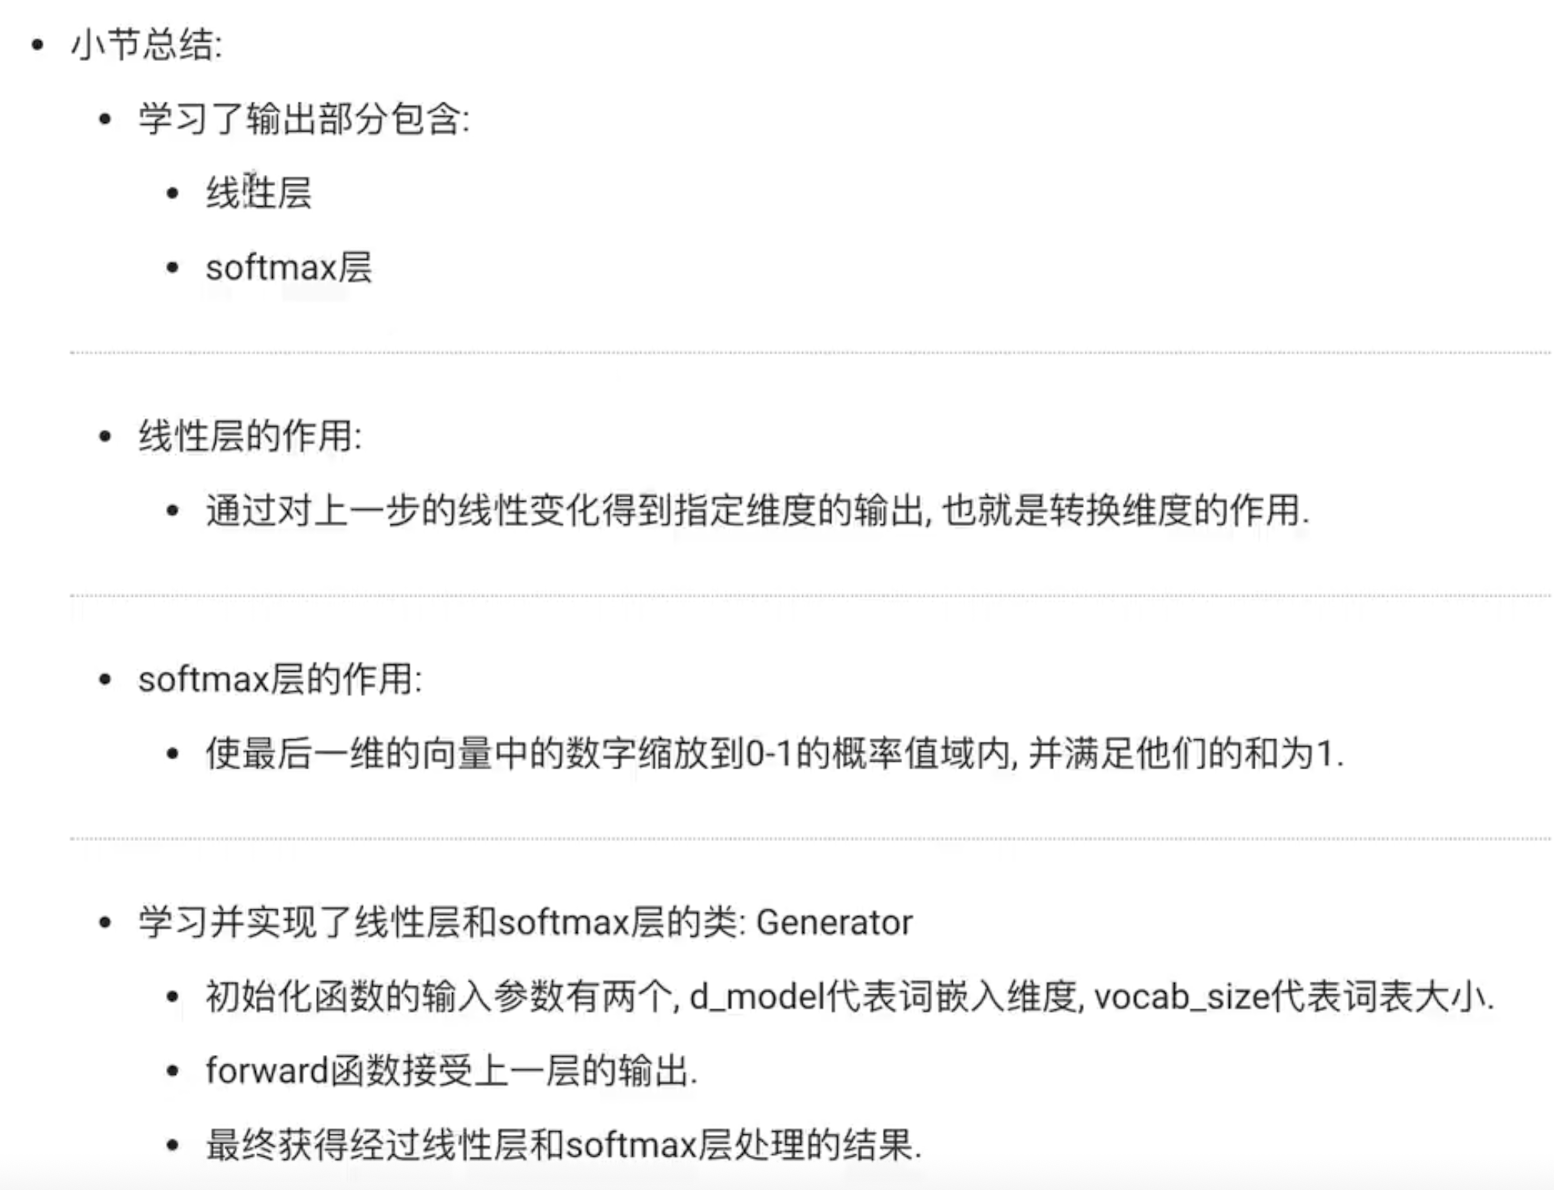